# Chronological Attribution of ancient texts using deep NNs

In [1]:
import pandas as pd
import numpy as np

import data_explore
import genfunctions

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from genfunctions import create_regression_mlp
from genfunctions import ngram_vectorize

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time
import os
import sys

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Input
from tensorflow.python.keras.layers import Dropout

from sklearn.metrics import mean_squared_error
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras import Sequential

from tensorflow.keras.utils import plot_model
import pydot




%matplotlib inline

In [2]:
# Start time of Execution
time_start = time()

In [3]:
data = pd.read_csv('iphi2802.csv', sep= '\t')
df = pd.DataFrame(data)

### Exploratory Data Analysis

In [4]:
df.head()

,id,text,metadata,region_main_id,region_main,region_sub_id,region_sub,date_str,date_min,date_max,date_circa
0,315181,[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισι...,Boiotia — Thespiai — mid-3rd c. BC — BCH 26 (1...,1698,Central Greece (IG VII-IX),1691,"Megaris, Oropia, and Boiotia (IG VII)",mid-3rd c. BC,-275.0,-226.0,0.0
1,201686,μαλκοιδων ηρωνος.,"Crete, W. — Tarrha — 1st-3rd c. AD — IC II xxi...",1699,"Aegean Islands, incl. Crete (IG XI-[XIII])",474,Crete,1st-3rd c. AD,1.0,300.0,0.0
2,153178,βασιλικος.,Makedonia (Bottiaia) — Pella — 3rd/2nd c. BC —...,1692,Northern Greece (IG X),1485,Macedonia,3rd/2nd c. BC,-300.0,-101.0,0.0
3,28582,αισκλαπιει μ [ανεθεκε --].,Epidauria — Epidauros — sinistr. — 6th/5th c. BC,1690,Peloponnesos (IG IV-[VI]),1643,"Epidauria (IG IV²,1)",6th/5th c. BC,-600.0,-401.0,0.0
4,333620,[---]ος αν[εθηκε δαματρι].,Italia — Herakleia (Policoro) — late 4th/early...,1696,"Sicily, Italy, and the West (IG XIV)",1689,"Italy, incl. Magna Graecia",late 4th/early 3rd c. BC,-350.0,-251.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2802 non-null   int64  
 1   text            2802 non-null   object 
 2   metadata        2802 non-null   object 
 3   region_main_id  2802 non-null   int64  
 4   region_main     2802 non-null   object 
 5   region_sub_id   2802 non-null   int64  
 6   region_sub      2802 non-null   object 
 7   date_str        2802 non-null   object 
 8   date_min        2802 non-null   float64
 9   date_max        2802 non-null   float64
 10  date_circa      2802 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 240.9+ KB


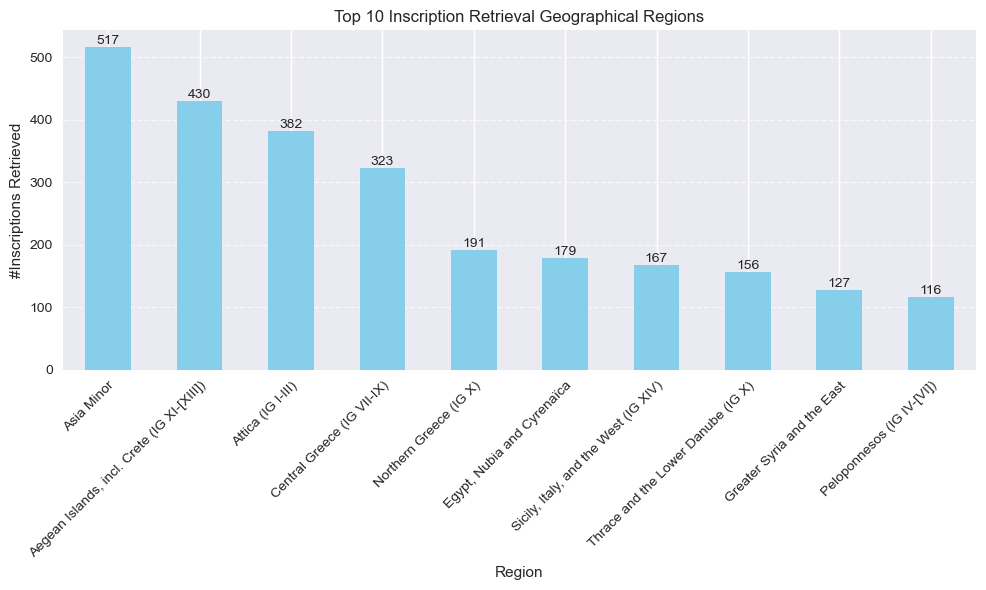

In [6]:
region_main_dict = {key: value for key, value in zip(df['region_main_id'], df['region_main'])}
region_sub_dict = {key: value for key, value in zip(df['region_sub_id'], df['region_sub'])}
region_dict = {
    'region_main_dict': region_main_dict,
    'region_sub_dict': region_sub_dict
}
# Plot the histogram
plt.figure(figsize=(10, 6))
bars = df['region_main_id'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Inscription Retrieval Geographical Regions')
plt.xlabel('Region')
plt.ylabel('#Inscriptions Retrieved')
plt.xticks(range(len(df['region_main_id'].value_counts().head(10))), [region_main_dict[key] for key in df['region_main_id'].value_counts().head(10).index], rotation=45, ha='right', rotation_mode='anchor')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.tight_layout()

plt.show()

### Data Preprocessing

In [7]:
text = df['text']

df = df.assign(date_mean=(df['date_min'] + df['date_max']) / 2)

labels = df['date_mean']


(7.0, 81315)


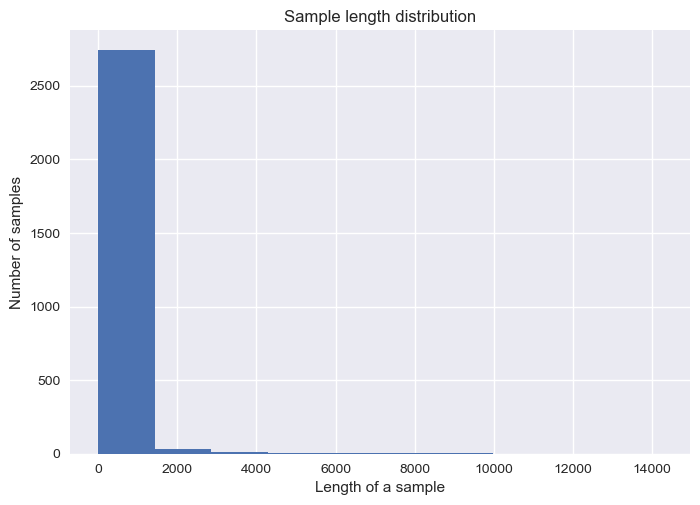

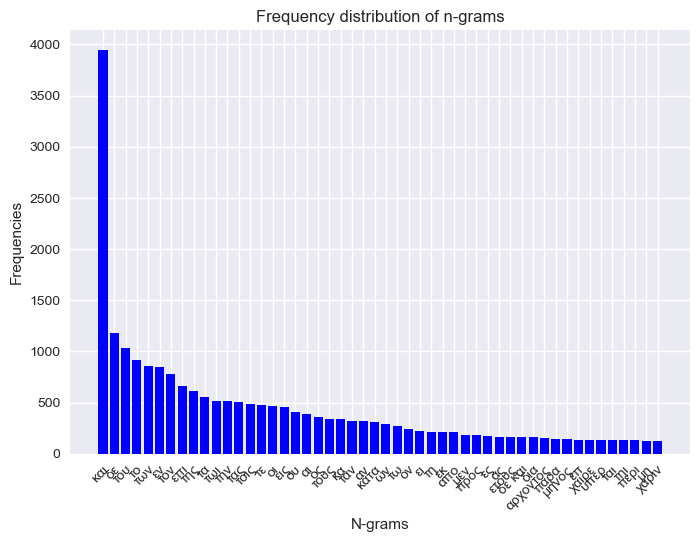

In [8]:
print(data_explore.get_num_words_per_sample(text))
ave, ngrams = data_explore.get_num_words_per_sample(text)
data_explore.plot_sample_length_distribution(text)
data_explore.plot_frequency_distribution_of_ngrams(text)

In [9]:
print(f'#Samples / average_number_of_words_per_sample = {2802/ave:.2f}')

#Samples / average_number_of_words_per_sample = 400.29


In [10]:
# Split data
text_train, text_test, labels_train, labels_test = train_test_split(text, labels, test_size=.3, random_state=42) 

In [11]:
T_train, T_test = ngram_vectorize(text_train, labels_train, text_test)

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2065: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [12]:
print(f'Train Set size: {T_train.shape}, Test Set size: {T_test.shape}')

Train Set size: (1961, 623), Test Set size: (841, 623)


### Scaling

In [13]:
scaler = StandardScaler(with_mean=False)

# Fit the scaler to your data (computes mean and standard deviation)
scaler.fit(T_train)
# Transform your data using the scaler (standardizes the data)
T_train_scaled = scaler.transform(T_train)
T_test_scaled = scaler.transform(T_test)


In [14]:
scaler1 = MinMaxScaler()

data_column = labels.values.reshape(-1, 1)

# Fit the scaler to the data column
scaler.fit(data_column)

# Transform the data column using the fitted scaler
scaled_column = scaler.transform(data_column)


scaled_labels = pd.DataFrame(scaled_column, columns=['scaled_labels'])  # Replace 'scaled_labels' with your preferred column name


In [15]:
scaled_labels.head()

,scaled_labels
0,-0.903188
1,0.542634
2,-0.722911
3,-1.804574
4,-1.083466


In [16]:
T_train_scaled.shape

(1961, 623)

# Neural Network

In [17]:
input_data_shape = T_train_scaled[2].T.shape
input_data_shape = (623,)
input_data_shape = T_train_scaled.shape[1:]
print("Type of the input shape object:", type(input_data_shape))
input_data_shape

Type of the input shape object: <class 'tuple'>


(623,)

In [18]:
n_outputs = 1
print("Number of outputs the model to predict:", n_outputs)

Number of outputs the model to predict: 1


In [19]:
models = []
testmae = []

#### Neural Network Architecture and Model Instantiation

In [197]:
# Define the ANN architecture
model = Sequential()

# model.add(layers.Input(shape=input_data_shape))
model.add(layers.Dense(64, activation='relu', input_shape=input_data_shape))          
model.add(layers.Dense(n_outputs)) 
    


# model = keras.Sequential(
#     [
#         layers.Dense(2, activation="relu"),
#         layers.Dense(3, activation="relu"),
#         layers.Dense(4),
#     ]

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [198]:
#tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, expand_nested=True, dpi=96, rankdir='TB', prog='/opt/homebrew/bin/dot')


In [199]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,001 (156.25 KB)

 Trainable params: 40,001 (156.25 KB)

 Non-trainable params: 0 (0.00 B)

In [200]:
# Build the NN model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['mae'])

In [201]:
nn_prms = config['fit']
nn_prms

NameError: name 'config' is not defined

#### NN Model Training

In [202]:
total_samples = T_train_scaled.shape[0]
total_samples = 1344
# labels = np.concatenate((labels_train, labels_test))
labels = scaled_labels[:1344]
train_size = int(0.7 * total_samples)
test_size = int(0.15 * total_samples)
val_size = int(0.15 * total_samples)

X_train = T_train_scaled[:train_size]
X_test = T_train_scaled[train_size:train_size+test_size]
X_val = T_train_scaled[train_size+test_size:1344]

y_train = labels[:train_size]
y_test = labels[train_size:train_size+test_size]
y_val = labels[train_size+test_size:1344]

In [203]:
# Check the shapes of the input data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Check the maximum indices used for slicing
print("Maximum index for X_train:", train_size)
print("Maximum index for X_train:", train_size + test_size)
print("Maximum index for X_val:", train_size + test_size + val_size)

# Check if the maximum indices exceed the actual data size
print("Is maximum index for X_train within range?", train_size <= total_samples)
print("Is maximum index for X_val within range?", train_size + test_size + val_size <= total_samples)


X_train shape: (940, 623)
y_train shape: (940, 1)
X_test shape: (201, 623)
y_test shape: (201, 1)
X_val shape: (203, 623)
y_val shape: (203, 1)
Maximum index for X_train: 940
Maximum index for X_train: 1141
Maximum index for X_val: 1342
Is maximum index for X_train within range? True
Is maximum index for X_val within range? True


In [204]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print(len(y_test.shape))

X_train shape: (940, 623)
y_train shape: (940, 1)
2


In [205]:
# Train the model
tf.data.experimental.enable_debug_mode()
history = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val, y_val), verbose='auto')
# history = model.fit(T_train_scaled, labels_train, batch_size=16, epochs=10, validation_data=(T_test_scaled, labels_test), verbose='auto')

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5019 - mae: 1.1680 - val_loss: 1.7111 - val_mae: 1.0393
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0473 - mae: 0.7823 - val_loss: 1.4799 - val_mae: 1.0013
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7202 - mae: 0.6429 - val_loss: 1.7430 - val_mae: 1.0685
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5681 - mae: 0.5445 - val_loss: 1.4690 - val_mae: 0.9853
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6003 - mae: 0.5603 - val_loss: 1.5862 - val_mae: 1.0227
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5184 - mae: 0.4968 - val_loss: 1.4241 - val_mae: 0.9733
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5344 - mae: 0.4998 - val_loss: 1.6009 - val_mae: 1.0153
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5078 - mae: 0.4894 - val_loss: 1.4513 - val_mae: 0.9767
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

#### NN Model Evaluation

In [206]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test.reshape(-1, *input_data_shape), y_test)
testmae += [test_mae]
print("Test Loss:", test_loss)
print("Test RMSE:", test_mae)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5998 - mae: 0.9451
Test Loss: 1.6118725538253784
Test RMSE: 0.9845868945121765


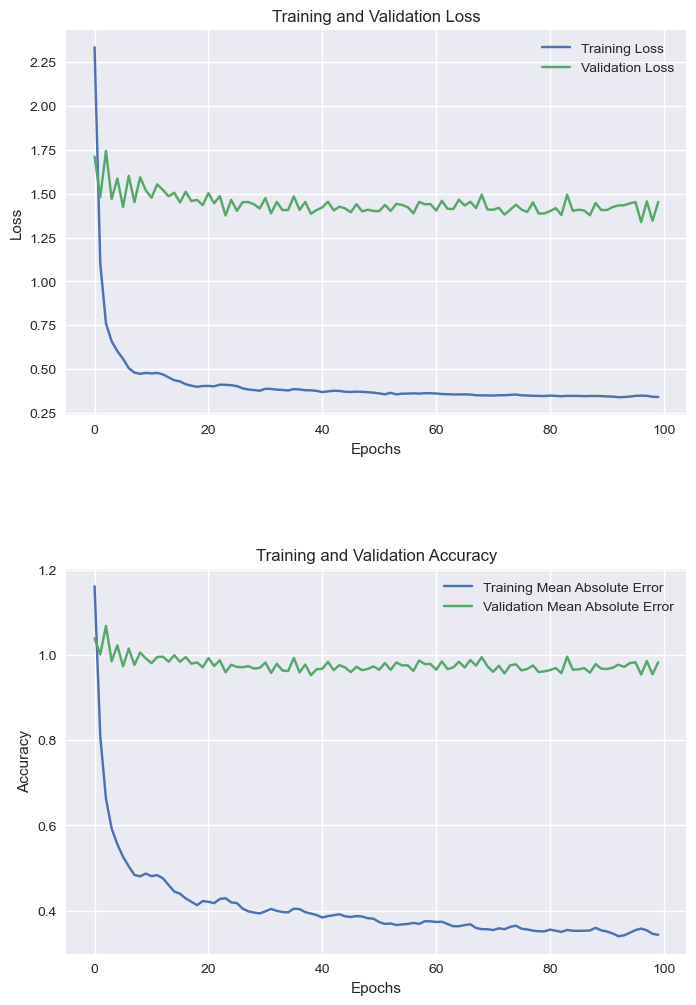

In [207]:
genfunctions.plot_metrics(history)

# Draft

In [ ]:
def create_regression_mlp(input_shape, x_train, train_labels, epochs, validation_data, batch_size):
    # Define the model architecture
    model = models.Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape),
        layers.Dense(1)  # Output layer with single unit for regression
    ])
    
    # Compile the model
    #opt = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    opt='adam'
    model.compile(optimizer=opt, loss='mean_squared_error')
    
    # Train the model
    history = model.fit(
        x_train,
        train_labels,
        epochs=epochs,
        validation_data=validation_data,
        verbose=2,
        batch_size=batch_size
    )
    
    # Print results
    print('Validation loss:', history.history['val_loss'][-1])
    
    return model

In [34]:
train_data = (T_train_scaled, labels_train)  # Tuple of training texts and labels
test_data = (T_test_scaled, labels_test)  # Tuple of validation texts and labels


model = create_regression_mlp(
    input_shape=T_train_scaled.shape[1:],
    x_train=T_train_scaled,
    train_labels=labels_train,
    epochs=100,
    validation_data=test_data,  # Providing test_data as validation data
    batch_size=32)

Epoch 1/100


/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 - 0s - 5ms/step - loss: 74851.0625 - val_loss: 82482.0234
Epoch 2/100
62/62 - 0s - 871us/step - loss: 74165.1875 - val_loss: 81654.3672
Epoch 3/100
62/62 - 0s - 835us/step - loss: 72968.4062 - val_loss: 80352.4297
Epoch 4/100
62/62 - 0s - 866us/step - loss: 71313.5312 - val_loss: 78766.8281
Epoch 5/100
62/62 - 0s - 809us/step - loss: 69400.9531 - val_loss: 77061.2734
Epoch 6/100
62/62 - 0s - 834us/step - loss: 67397.1172 - val_loss: 75439.5547
Epoch 7/100
62/62 - 0s - 888us/step - loss: 65454.4648 - val_loss: 73959.3125
Epoch 8/100
62/62 - 0s - 839us/step - loss: 63645.4062 - val_loss: 72633.3594
Epoch 9/100
62/62 - 0s - 828us/step - loss: 61986.1992 - val_loss: 71462.6875
Epoch 10/100
62/62 - 0s - 825us/step - loss: 60423.1016 - val_loss: 70439.5156
Epoch 11/100
62/62 - 0s - 795us/step - loss: 59003.2852 - val_loss: 69550.8828
Epoch 12/100
62/62 - 0s - 812us/step - loss: 57648.0820 - val_loss: 68727.8281
Epoch 13/100
62/62 - 0s - 798us/step - loss: 56392.6641 - val_loss: 68044.0

In [192]:
print(f'Took {(time() - time_start) / 60:.2f} minutes!')

Took 84.94 minutes!
